# 6.6 Sourcing & Analyzing Time-Series Data - Milena Nedyalkova

### This script contains the following:

#### 1. Importing libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity

### 1. Importing your libraries and data

In [151]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore") 
plt.style.use('fivethirtyeight') # Styling option for how plots will appear.

In [152]:
# File path and name
data_path = r'C:\\Users\\PC\\Desktop\\CareerFoundry Data Analytics\\big_data_air_traffic.csv'
data = pd.read_csv(data_path)

The initial dataset included only the year 2024. To extend the time horizon, I retrieved additional data for 2023 and 2022 from the same source and combined the three yearly files using the CONCAT function in a separate workbook. For the purposes of this analysis, I narrowed the scope to a single country — Greece. The flight counts were aggregated by date and country, after which a subset containing only Greece was extracted. This subset, derived from the main dataset, forms the basis of the present exercise.

In [153]:
data.columns

Index(['Unnamed: 0', 'YEAR', 'MONTH_NUM', 'MONTH_MON', 'FLT_DATE', 'APT_ICAO',
       'APT_NAME', 'STATE_NAME', 'FLT_DEP_1', 'FLT_ARR_1', 'FLT_TOT_1',
       'FLT_DEP_IFR_2', 'FLT_ARR_IFR_2', 'FLT_TOT_IFR_2'],
      dtype='object')

In [154]:
# Remove the columns that are not required for the analysis 
data = data.drop(['Unnamed: 0', 'YEAR', 'MONTH_NUM','MONTH_MON', 'APT_ICAO', 'APT_NAME', 'FLT_DEP_1', 'FLT_ARR_1', 'FLT_DEP_IFR_2', 'FLT_ARR_IFR_2', 'FLT_TOT_IFR_2'],axis=1)

In [156]:
# Rename the columns
data = data.rename(columns={'FLT_DATE': 'Flight Date', 'STATE_NAME': 'Country', 'FLT_TOT_1' : 'Total Flights' })

In [177]:
data.dtypes

Flight Date      object
Country          object
Total Flights     int64
dtype: object

#### 2. Subsetting, wrangling, and cleaning time-series data

In [178]:
df = pd.DataFrame(data)

# Convert 'Flight Date' to datetime
df['Flight Date'] = pd.to_datetime(df['Flight Date'])

# Group by 'Flight Date' and sum 'Total flights'
daily_sum = df.groupby('Flight Date')['Total Flights'].sum().reset_index()
daily_sum.rename(columns={'Total Flights': 'Total flights per day'}, inplace=True)

# Merge the summed values back into the original dataframe
df = df.merge(daily_sum, on='Flight Date')

In [179]:
# Filter the flights for Greece 
greece_df = data[data['Country'] == 'Greece']

print(greece_df)

       Flight Date Country  Total Flights
89      2024-01-01  Greece            458
90      2024-01-01  Greece             28
91      2024-01-01  Greece              3
92      2024-01-01  Greece             12
93      2024-01-01  Greece             10
...            ...     ...            ...
342782  2022-12-31  Greece             17
342783  2022-12-31  Greece              3
342784  2022-12-31  Greece             18
342785  2022-12-31  Greece             89
342786  2022-12-31  Greece              2

[13680 rows x 3 columns]


In [180]:
# Aggregate daily flights
greece_daily = greece_df.groupby('Flight Date', as_index=False)['Total Flights'].sum()

greece_daily.head(15)

,Flight Date,Total Flights
0,2022-01-01,418
1,2022-01-02,740
2,2022-01-03,747
3,2022-01-04,642
4,2022-01-05,671
5,2022-01-06,644
6,2022-01-07,757
7,2022-01-08,676
8,2022-01-09,719
9,2022-01-10,669


In [149]:
print(greece_daily.columns)

Index(['Total Flights'], dtype='object')


In [159]:
# Convert 'Flight Date' to datetime and set the flight date as the index of the dataframe.

greece_daily["Flight Date"] = pd.to_datetime(greece_daily["Flight Date"])
greece_daily = greece_daily.set_index("Flight Date") 


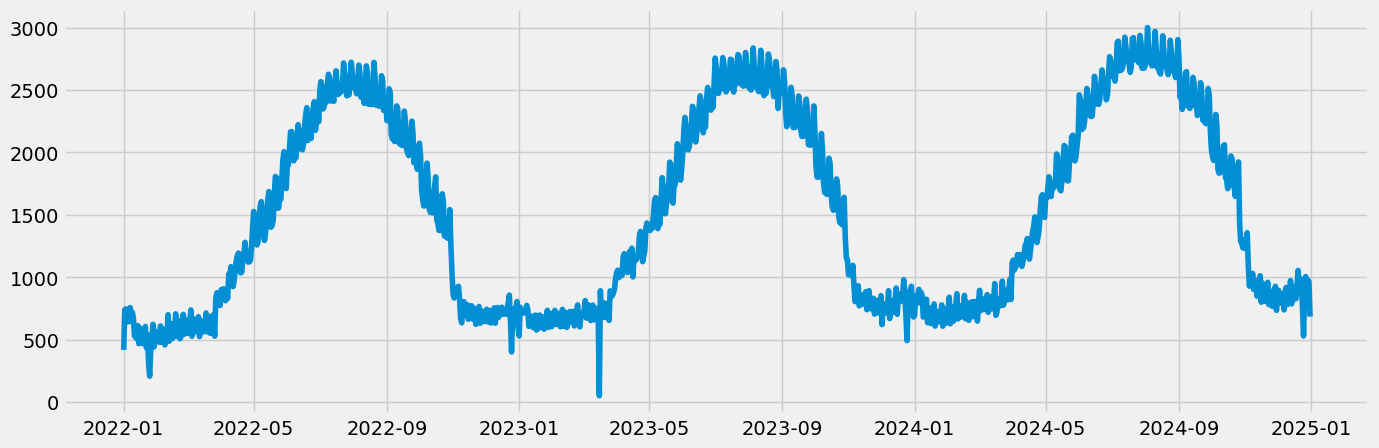

In [163]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 

plt.plot(greece_daily)

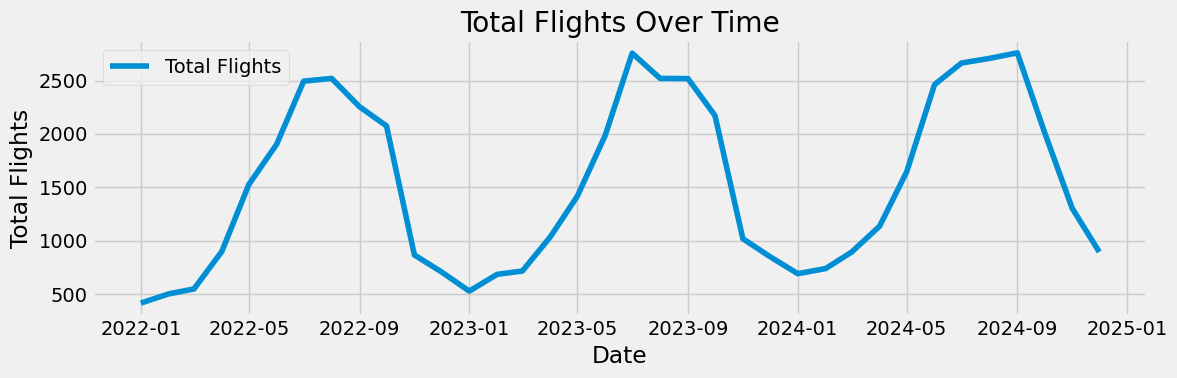

In [166]:
# Create a line chart of the data subset

ts = greece_daily["Total Flights"].asfreq("MS")   

plt.figure(figsize=(12,4))
plt.plot(ts, label="Total Flights")
plt.title("Total Flights Over Time")
plt.xlabel("Date")
plt.ylabel("Total Flights")
plt.legend()
plt.tight_layout()
plt.show()

A strong seasonal pattern is evident, with flight activity consistently peaking during the summer months of June to August, when volumes surpass 2,500 flights. This peak is followed by a pronounced decline in autumn, reaching the lowest levels during the winter months of December to February, where flight activity typically falls to around 500–800 flights. The cyclical nature of the data repeats regularly across all three years, underscoring the strong influence of tourism on air travel in Greece. 

In addition to this seasonal pattern, the peaks across the years display a slight upward tendency, suggesting a gradual growth in total air traffic over the observed period. This indicates both the persistence of seasonality in Greek flight activity and the potential for long-term expansion of the aviation sector.

### 3. Time-series analysis: decomposition

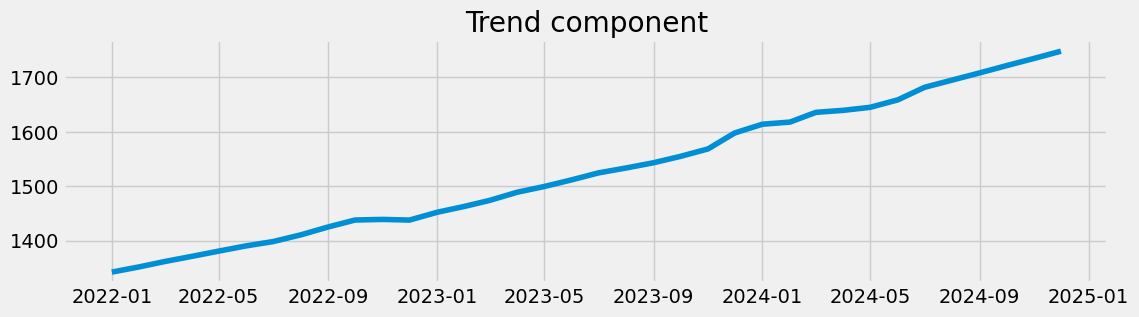

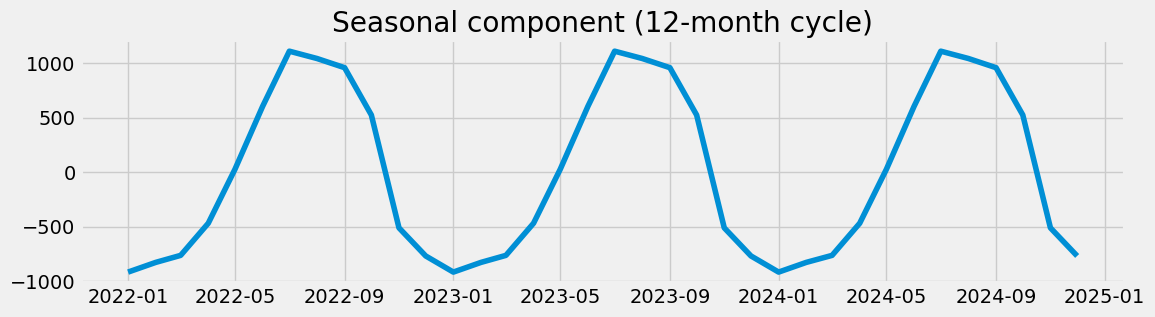

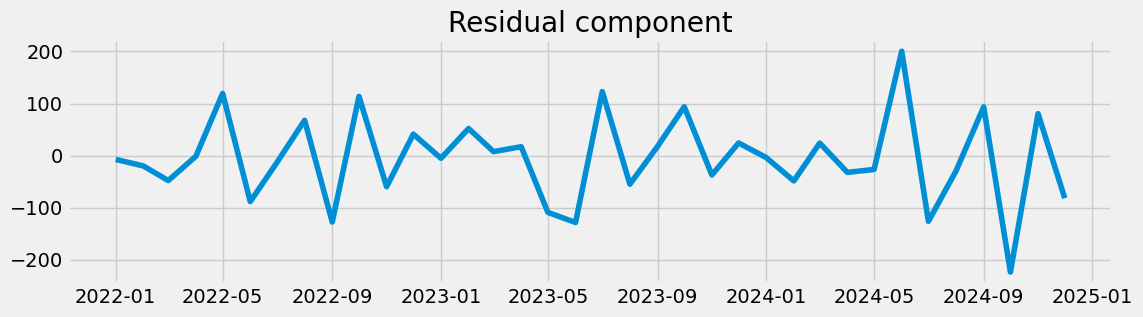

In [167]:
decomp = sm.tsa.seasonal_decompose(ts, model="additive", period=12, extrapolate_trend="freq")

plt.figure(figsize=(12,3))
plt.plot(decomp.trend)
plt.title("Trend component")
plt.show()

plt.figure(figsize=(12,3))
plt.plot(decomp.seasonal)
plt.title("Seasonal component (12-month cycle)")
plt.show()

plt.figure(figsize=(12,3))
plt.plot(decomp.resid)
plt.title("Residual component")
plt.show()


The trend component shows a steady upward trajectory from early 2022 through the end of 2024, indicating a gradual long-term increase in flight activity over the observed period. The seasonal component reflects a pronounced 12-month cycle, with strong peaks during the summer months and sharp declines in winter, consistent with the strong influence of tourism on air travel demand in Greece. This repeating seasonal pattern confirms that flight volumes are highly dependent on holiday periods. The residual component captures the irregular fluctuations that are not explained by trend or seasonality. These residuals remain relatively small compared to the overall series, suggesting that the bulk of the variability is well explained by the underlying trend and seasonal structure. Overall, the decomposition highlights both the structural growth in air traffic and the strong seasonal dynamics that dominate the Greek aviation market.

### 4. Testing for stationarity

In [172]:
# Dickey-Fuller test function

from statsmodels.tsa.stattools import adfuller 

def adf_test(series, title="ADF Test"):
    print(f"\n{title}")
    result = adfuller(series.dropna(), autolag="AIC")
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations']
    out = pd.Series(result[0:4], index=labels)
    for key, val in result[4].items():
        out[f"Critical Value ({key})"] = val
    print(out.to_string())
    if result[1] < 0.05:
        print("=> Reject H0: The series is stationary.")
    else:
        print("=> Fail to reject H0: The series is non-stationary.")
    return result[1]

# Test on original series
pval = adf_test(ts, "ADF Test on Original Series")


ADF Test on Original Series
ADF Statistic           -0.868658
p-value                  0.798119
# Lags Used             10.000000
# Observations          25.000000
Critical Value (1%)     -3.723863
Critical Value (5%)     -2.986489
Critical Value (10%)    -2.632800
=> Fail to reject H0: The series is non-stationary.


In [ ]:
# Run another round of differencing 

In [173]:
ts_seasonal_diff = ts.diff(12).dropna()
adf_test(ts_seasonal_diff, "ADF Test after Seasonal Differencing (lag=12)")


ADF Test after Seasonal Differencing (lag=12)
ADF Statistic          -7.165272e+00
p-value                 2.897347e-10
# Lags Used             0.000000e+00
# Observations          2.300000e+01
Critical Value (1%)    -3.752928e+00
Critical Value (5%)    -2.998500e+00
Critical Value (10%)   -2.638967e+00
=> Reject H0: The series is stationary.


np.float64(2.8973470857675457e-10)

The test on the original series produced a high p-value (0.80) and an ADF statistic (–0.87) greater than the critical values, indicating that the null hypothesis of a unit root cannot be rejected and the series is non-stationary. After applying seasonal differencing with lag 12, the ADF statistic dropped significantly to –7.17 with an extremely small p-value (<0.000000001), well below all critical values. This allows us to reject the null hypothesis and conclude that the differenced series is stationary.

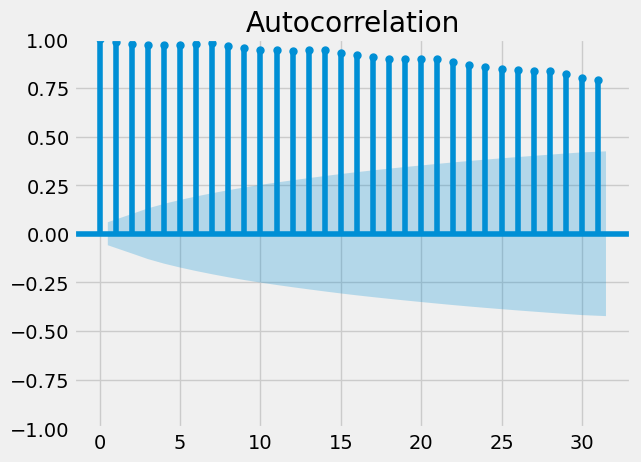

In [176]:
# Check the Autocorrelation

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(greece_daily)
plt.show()

This autocorrelation plot shows that the autocorrelation values remain very high and decay only slowly across many lags, staying well outside the confidence bands. This is a strong indication of non-stationarity in the original series. The slow decline suggests the presence of a unit root or strong trend/seasonality in the data, consistent with our earlier ADF test results before differencing.